# Trading Places
1. Read in data using Dask __(1 point)__
2. Descriptive Statistics: __(2 points)__
    
    a. In the year 2012, who were the top 10 countries with the most trading partners? What about the bottom 10?
    
    b. Using the designation [here]( https://www.foreign-trade.com/reference/hscode.htm), describe the trade volume of the whole dataset in terms of value and list the five highest value sectors in the entire sample period.

3. Country statistics: __(3 points)__

    a. Calculate the top 10 exports (in terms of value) of our chosen country in 2012.

    b. Calculate the top 10 goods with the highest trade volume in the entire dataset in terms of:
    
        i. Value
    
        ii. Quantity

3. The Gravity Equation Relationship __(4 points)__

    a. Using the country shapefile, calculate the distance in kilometers between the centroid of our chosen country and all the other centroids in each row using haversine distance.
    
    b. Using the country we chose in class, create a scatterplot of distance and trade flow volume (quantity and value) in logarithm form.
    
    c. Calculate the correlations between trade volume and distance for both value and quantity. Interpret the correlations for each of these factors.
    
    d. Using the designation you created in 2.d., for which sectors are trade flows (quantity) most strongly related to distance for this country?
    
4. Estimation __(6 points)__
    
    a. Create a function called "SSE_1p" that does the following given a scalar input $\beta$:
        1. subtracts the logarithm of quantity flow from the logarithm of distance times $\beta$.
$$ e = log(F_{ij}) - \beta log(d_{ij}) $$
        2. Squares the error.
        3. Returns the sum of the squared error. 
    b. Plot the function from -1 to +3 with steps of .005, and then find the minimum of the function with the numpy function "argmin." Is it what you expected?
    
    c. Create another function called "SSE_2p" does the same as "SSE_1p" but instead takes a __vector__ as an argument:
 $$ e = log(F_{ij}) - \beta[0] - \beta[1] log(d_{ij})$$
 
     d. Do a grid search with the first parameter range as 1500 to 2500 in steps of 10, and the second parameter range as -1 to +3 in steps of .005 as before. Do it using either `dask` or `multiprocessing`. Comment on how or why the parameter on $log(d_{ij})$ is different than what you found in part 4b.
     
     e. Now check your results using the "econtools" package "reg" function by running OLS with a constant term.
     
     f. Finally, merge in the GDP numbers from the World Bank and do the regression again, except this time the log of each country's GDP as covariates. How did the coefficient on distance change?
     
5. An analyst asks you "for which commodity sectors is distance most important in terms of exporting?" Describe what your economic intuition would say about the answer, and then also map out an analysis strategy for answering their question. As usual, describe: __(4 points)__
    - What data you would need.
    - How you would manipulate the data.
    - What analysis you would run.

In [30]:
import glob
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import json
import dask
import geopandas as gp
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt


def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = row
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# 1. Read in Dask Data

In [2]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:60808 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 2.00 GB


In [31]:
import dask.dataframe as dd
df = dd.read_csv('/Users/noahgonzales/Desktop/Homework 3/baci/BACI*.csv')

In [32]:
df

,t,i,j,k,v,q
npartitions=42,,,,,,
,int64,int64,int64,int64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [5]:
df.head(5)

,t,i,j,k,v,q
0,2012,4,8,610469,2.734000,0.044
1,2012,4,12,91099,1.185000,1.200
2,2012,4,32,392630,1.274453,0.123
3,2012,4,32,730729,2.018000,0.100
4,2012,4,32,853400,5.530000,0.028


# 2. Descriptive Statistics

In [16]:
df.npartitions

42

In [17]:
df.partitions[3].compute()

,t,i,j,k,v,q
0,2012,554,36,621520,264.118684,1.524000
1,2012,554,36,621590,13.982460,0.066000
2,2012,554,36,621600,64.804601,1.879000
3,2012,554,36,621710,335.961330,10.766000
4,2012,554,36,621790,5.680674,0.098000
...,...,...,...,...,...,...
1419131,2012,752,381,691200,73.248859,8.535434
1419132,2012,752,381,691310,13.051901,0.096012
1419133,2012,752,381,691390,11.130867,1.116331
1419134,2012,752,381,691490,12.151856,0.719000


In [33]:
df = df.set_index('t', sorted=True)

In [34]:
df.known_divisions

True

In [35]:
df.divisions

(2012,
 2012,
 2012,
 2012,
 2012,
 2013,
 2013,
 2013,
 2013,
 2013,
 2013,
 2014,
 2014,
 2014,
 2014,
 2014,
 2014,
 2015,
 2015,
 2015,
 2015,
 2015,
 2015,
 2016,
 2016,
 2016,
 2016,
 2016,
 2016,
 2017,
 2017,
 2017,
 2017,
 2017,
 2017,
 2017,
 2018,
 2018,
 2018,
 2018,
 2018,
 2018,
 2018)

## a) In the year 2012, who were the top 10 countries with the most trading partners? What about the bottom 10?

In [21]:
df_2012 = df.loc[2012]
df_2012

,i,j,k,v,q
npartitions=1,,,,,
2012,int64,int64,int64,float64,float64
2012,...,...,...,...,...


In [22]:
df_2012.head()

,i,j,k,v,q
t,,,,,
2012,554,36,621520,264.118684,1.524
2012,554,36,621590,13.982460,0.066
2012,554,36,621600,64.804601,1.879
2012,554,36,621710,335.961330,10.766
2012,554,36,621790,5.680674,0.098


In [ ]:
top_importers = df_2012.groupby('i').i.count().nlargest(10).compute()

In [14]:
top_importers ## Top 10 importers

i
842    326867
826    263243
724    220258
792    176323
757    142958
616    130448
752    128977
764    126442
699    122070
784    115991
Name: i, dtype: int64

In [ ]:
bottom_importers = df_2012.groupby('i').i.count().nsmallest(10).compute()

In [16]:
bottom_importers  ## Bottom 10 exporters

i
728     27
876     43
574     44
612     54
585     71
624     73
580     76
798    100
583    103
570    122
Name: i, dtype: int64

In [ ]:
top_exporters = df_2012.groupby('j').i.count().nlargest(10).compute()

In [18]:
top_exporters

j
276    65065
251    57253
842    54406
381    54034
826    50126
528    45953
784    45077
156    44609
58     42266
36     39676
Name: i, dtype: int64

In [ ]:
bottom_exporters = df_2012.groupby('j').i.count().nsmallest(10).compute()

In [20]:
bottom_exporters

j
166     16
666     30
535     36
612     45
520     73
162     75
260    102
86     123
16     126
798    160
Name: i, dtype: int64

## b) 

<AxesSubplot:>

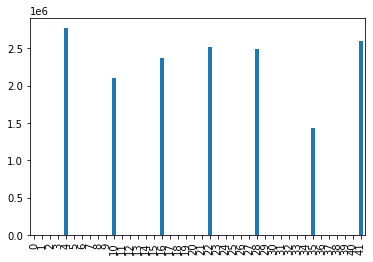

In [36]:
df.map_partitions(len).compute().plot(kind='bar')

<AxesSubplot:>

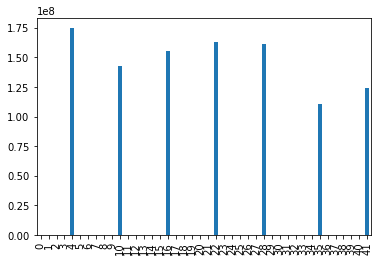

In [37]:
def mem_usage(x): 
    return x.memory_usage().sum()

df.map_partitions(mem_usage).compute().plot(kind='bar')

In [38]:
df

,i,j,k,v,q
npartitions=42,,,,,
2012,int64,int64,int64,float64,float64
2012,...,...,...,...,...
...,...,...,...,...,...
2018,...,...,...,...,...
2018,...,...,...,...,...


In [39]:
highest_values = df.groupby("k")['v'].count().nlargest(5).compute() ## Keep Trying this one

In [40]:
highest_values

k
392690    17584
732690    16051
870899    15406
850440    15187
851762    15018
Name: v, dtype: int64

In [54]:
product_codes = pd.read_csv('/Users/noahgonzales/Desktop/Homework 3/product_codes_HS12_V202001.csv')


In [ ]:
country_codes = pd.read_csv('/Users/noahgonzales/Desktop/Homework 3/country_codes_V202001',encoding = 'utf-8')

In [58]:
product_codes = product_codes.rename(columns={'code':'k'})

In [59]:
df_wdes = df.merge(product_codes)

In [60]:
df_wdes

,i,j,k,v,q,description
npartitions=42,,,,,,
,int64,int64,int64,float64,float64,object
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [64]:
Largest_values = df_wdes.groupby("description")['v'].count().nlargest(5).compute()

In [65]:
Largest_values

description
Plastics: other articles n.e.c. in chapter 39                                                                                                                                                                             17584
Iron or steel: articles n.e.c.in heading 7326                                                                                                                                                                             16051
Vehicle parts and accessories: n.e.c. in heading no. 8708                                                                                                                                                                 15406
Electrical static converters                                                                                                                                                                                              15187
Communication apparatus (excluding telephone sets or base stations): machines for the recept

## 3. Country Statistics

### a) Calculate the top 10 exports (in terms of value) of our chosen country in 2012.

In [68]:
df_2012 = df_wdes.loc[2012]
df_2012

,i,j,k,v,q,description
npartitions=42,,,,,,
,int64,int64,int64,float64,float64,object
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [71]:
df_2012_brazil = df_2012.iloc[64]

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

In [69]:
# In 2012
# Calcualte top v (value)
# For i (brazil)



Brazil_top_exports = df_2012.groupby("i")['v'].count().nlargest(10).compute()

In [70]:
Brazil_top_exports

i
792    2
757    2
842    1
705    1
682    1
Name: v, dtype: int64